<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/Reccomendation_Engine_Matrix_Fact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip "/content/gdrive/My Drive/ml-1m.zip"

Archive:  /content/gdrive/My Drive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [79]:
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

In [80]:
#converting to user - item matrix
train_matrix = pd.pivot_table(ratings, index='user_id', columns='movie_id', values='rating')

In [81]:
arr = train_matrix.copy().values

In [82]:
#replacing random selected values with 99 for validation
def replace(orig, percentage=0.1):
  """
  Replaces 'percentage'% of the original values in 'orig' with 99's
  :param orig: original data array
  :param percentage: percentage of values to replace (0<percentage<1)
  """
  np.random.seed(35)
  new_data = orig.copy()
  rated = np.where(~np.isnan(arr))
  n_rated = len(rated[0])
  idx = np.random.choice(n_rated, size=int(percentage*n_rated), replace=False)
  new_data[rated[0][idx], rated[1][idx]] = 99
  return new_data, (rated[0][idx], rated[1][idx])

In [83]:
user_ratings,idx = replace(arr)

In [84]:
#initializing latent factors
n_latent_factors = 5

latent_user_preferences = np.random.random((train_matrix.shape[0], n_latent_factors))
latent_item_features = np.random.random((train_matrix.shape[1], n_latent_factors))

In [85]:
#the functions for SGD
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[train_matrix.index.get_loc(user_id)]
    item_preference = latent_item_features[train_matrix.columns.get_loc(item_id)]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0004):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[train_matrix.index.get_loc(user_id)]
    latent_user_preferences[train_matrix.index.get_loc(user_id)] -= alpha * err * latent_item_features[train_matrix.columns.get_loc(item_id)]
    latent_item_features[train_matrix.columns.get_loc(item_id)] -= alpha * err * user_pref_values
    return abs(err)
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    rmse_history = []
    mae_history = []
    for iteration in range(iterations):
        error = []
        for user_id in train_matrix.index:
            for item_id in train_matrix.columns:
                rating = user_ratings[train_matrix.index.get_loc(user_id), train_matrix.columns.get_loc(item_id)]
                if rating > 0 and rating < 6:
                    err = train(user_id, item_id, rating)
                    error.append(err)
        rmse = np.sqrt((np.array(error) ** 2).mean())   
        mae = np.mean(error)
        print('Iteration %d/%d:\tRMSE=%.6f,\tMAE=%.6f' % (iteration, iterations, rmse, mae))
        rmse_history.append(rmse)
        mae_history.append(mae)
    return rmse_history, mae_history


In [86]:
rmse_hist, mae_hist = sgd(25)

Iteration 0/25:	RMSE=2.121819,	MAE=1.850577
Iteration 1/25:	RMSE=1.493610,	MAE=1.227233
Iteration 2/25:	RMSE=1.270673,	MAE=1.022397
Iteration 3/25:	RMSE=1.164711,	MAE=0.929950
Iteration 4/25:	RMSE=1.101448,	MAE=0.876200
Iteration 5/25:	RMSE=1.059824,	MAE=0.841518
Iteration 6/25:	RMSE=1.030655,	MAE=0.817554
Iteration 7/25:	RMSE=1.009248,	MAE=0.800138
Iteration 8/25:	RMSE=0.992972,	MAE=0.787006
Iteration 9/25:	RMSE=0.980251,	MAE=0.776790
Iteration 10/25:	RMSE=0.970081,	MAE=0.768651
Iteration 11/25:	RMSE=0.961801,	MAE=0.762033
Iteration 12/25:	RMSE=0.954954,	MAE=0.756558
Iteration 13/25:	RMSE=0.949218,	MAE=0.751963
Iteration 14/25:	RMSE=0.944357,	MAE=0.748055
Iteration 15/25:	RMSE=0.940197,	MAE=0.744703
Iteration 16/25:	RMSE=0.936607,	MAE=0.741805
Iteration 17/25:	RMSE=0.933485,	MAE=0.739278
Iteration 18/25:	RMSE=0.930751,	MAE=0.737061
Iteration 19/25:	RMSE=0.928341,	MAE=0.735109
Iteration 20/25:	RMSE=0.926206,	MAE=0.733376
Iteration 21/25:	RMSE=0.924305,	MAE=0.731832
Iteration 22/25:	RMS

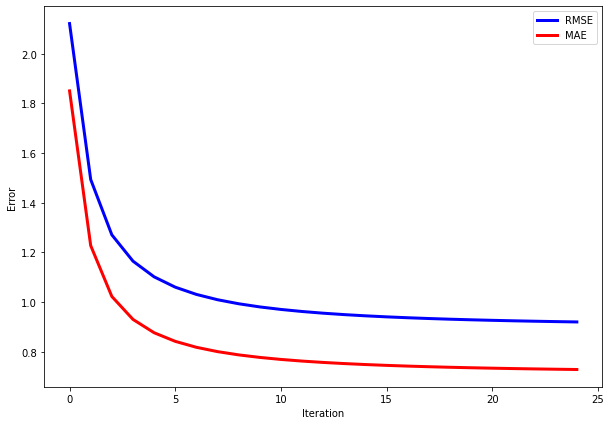

In [91]:
plt.figure(figsize=(10,7))
plt.plot(rmse_hist, label='RMSE', color='blue', linewidth=3)
plt.plot(mae_hist, label='MAE', color='red', linewidth=3)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()

In [92]:
#prediction for validation set
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


error_list = []
for i,j in zip(idx[0],idx[1]):
  error_list.append(predict_rating(i,j) - arr[i,j])

final_mse = np.sqrt((np.array(error_list)**2).mean())
print(final_mse)

0.9303892437356076


In [93]:
#prediction for nans
np.where(np.isnan(arr))

for i,j in zip(np.where(np.isnan(arr))[0], np.where(np.isnan(arr))[1]):
  arr[i,j] = predict_rating(i,j)


RECOMMENDATION

In [94]:
rec_matrix = pd.DataFrame(arr, columns=train_matrix.columns, index=train_matrix.index) 

In [95]:
#setting ratings to 0 for the movies that users have seen before
rec_matrix = rec_matrix * train_matrix.isna()

In [96]:
def recommender(user_id, prediction_matrix, num_of_rec = 10):

    predictions = prediction_matrix.loc[user_id].values

    rating_df   = pd.DataFrame({'movie_id': list(train_matrix.columns), 
                               'rating': predictions})
    final_df = rating_df.merge(movies, left_on='movie_id', right_on='movie_id').drop(['movie_id','genre'], axis=1)\
              .set_index('movie_name').sort_values('rating', ascending=False)[:num_of_rec]
    return final_df


In [100]:
#the movies that user 123 has already watched
recommender(123, train_matrix,5)

,rating
movie_name,
"Killing Fields, The (1984)",5.0
"Mission, The (1986)",5.0
Heat (1995),5.0
Saving Private Ryan (1998),5.0
Schindler's List (1993),5.0


In [101]:
#the movies that user 123 has already watched
recommender(123, rec_matrix,5)

,rating
movie_name,
"400 Blows, The (Les Quatre cents coups) (1959)",4.399316
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.358311
Wallace & Gromit: The Best of Aardman Animation (1996),4.356541
"Close Shave, A (1995)",4.350454
"Big Sleep, The (1946)",4.334967
